# **Лабораторная работа 3: Атаки уклонения на основе белого ящика против классификационных моделей на основе глубокого обучения**

Выполнил(а) студент **2** курса группы: **ББМО-02-23**

ФИО: **Кузина Анастасия Сергеевна**

## **Задание I. Обучить 2 классификатора на основе глубоких нейронных сетей на датасете GTSRB**

Использовать следующие модели нейронных сетей: VGG16, ResNet50/10X, MobileNet v2/3. Можно использовать фреймворки Keras, TensorFlow, PyTorch, не надо создавать сети вручную и с нуля. Использовать предобученные сети.

Выполнить поиск наилучших гиперпараметров моделей. Использовать бесплатные
ресурсы GPU сервиса Google Colab.

**Составить отчёт:**

(a) Заполнить Таблицу сравнения двух моделей (Пункт 2);

(b) Для каждой модели построить графики функции потерь для данных валидации и тестирования и графики метрики Accuracy (Пункт 3).

### **1. Начнем с подготовительного этапа для последующего выполнения задания:**

#### **1.1 Установим библиотеку Adversarial Robustness Toolbox (ART):**

In [ ]:
! pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.4 MB/s eta 0:00:00


#### **1.2 Импортируем необходимые для работы библиотеки:**

In [ ]:
import cv2
import kagglehub
import os
import torch
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

#### **1.3 Загружаем датасет gtsrb-german-traffic-sign:**

In [ ]:
dataset = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", dataset)

100%|██████████| 612M/612M [00:28<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


#### **1.4 Перейдем в директорию с полученными файлами и отобразим её  содержимое:**

In [ ]:
%cd $dataset
!ls

/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1
meta  Meta  Meta.csv  test  Test  Test.csv  train  Train  Train.csv


#### **1.5 Задаём пути к полученным данным датасета gtsrb-german-traffic-sign:**

In [ ]:
data_path = dataset
train_data_dataset = os.path.join(data_path, 'Train')
test_data_dataset = os.path.join(data_path, 'Test')
meta_data_dataset = os.path.join(data_path, 'Meta')

#### **1.6 Получим и выполним предварительную обработку изображений из треннировочного набора данных:**

In [ ]:
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_dataset, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
print("data[0]:\n",data[0])

data[0]:
 [[[0.47058824 0.49019608 0.5058824 ]
  [0.47058824 0.47843137 0.49803922]
  [0.4862745  0.4862745  0.5058824 ]
  ...
  [0.46666667 0.47058824 0.47843137]
  [0.4627451  0.46666667 0.45882353]
  [0.45490196 0.4627451  0.46666667]]

 [[0.4862745  0.49803922 0.50980395]
  [0.48235294 0.49019608 0.5019608 ]
  [0.47843137 0.48235294 0.5019608 ]
  ...
  [0.49019608 0.49411765 0.5137255 ]
  [0.4745098  0.47058824 0.4627451 ]
  [0.46666667 0.4509804  0.45490196]]

 [[0.49411765 0.5019608  0.5411765 ]
  [0.49803922 0.5058824  0.54901963]
  [0.4862745  0.49803922 0.54509807]
  ...
  [0.6039216  0.60784316 0.6313726 ]
  [0.5411765  0.52156866 0.5372549 ]
  [0.53333336 0.49019608 0.50980395]]

 ...

 [[0.34117648 0.36078432 0.3647059 ]
  [0.34901962 0.36078432 0.36078432]
  [0.3529412  0.35686275 0.36078432]
  ...
  [0.39607844 0.42745098 0.4509804 ]
  [0.36862746 0.3882353  0.4       ]
  [0.37254903 0.38431373 0.3882353 ]]

 [[0.33333334 0.34117648 0.34901962]
  [0.34117648 0.34901962 0.

#### **1.7 Просморим первый элемент данных в виде изображения:**

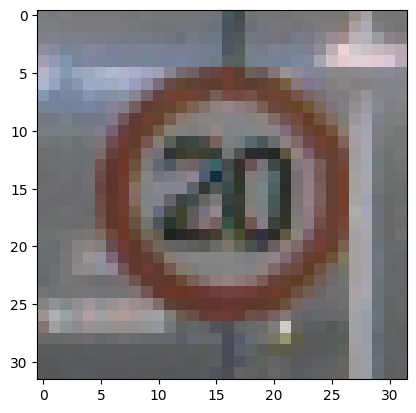

In [ ]:
plt.imshow(data[0])

#### **1.8 Выполним разделение данных на треннировочный и тестовый набор в оотношениях 70/30 и посмотрим полученные размерности наборов:**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)
print(y_train[0])

training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### **1.9 Создадим модель глубокого обучения для классификации изображений ResNet50:**

In [ ]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False
print(model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 23,545,643 (89.82 MB)

 Non-trainable params: 577,664 (2.20 MB)

None


#### **1.10 Обучаем модель, исользуя 10 эпох обучения. Включаем оптимизатор Adam и функцию потерь Categorical Crossentropy:**

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 10, batch_size = 64)

Epoch 1/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 112s 120ms/step - accuracy: 0.5648 - loss: 1.7203 - val_accuracy: 0.1154 - val_loss: 3.8291
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9362 - loss: 0.2404 - val_accuracy: 0.7479 - val_loss: 1.0308
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9578 - loss: 0.1613 - val_accuracy: 0.9665 - val_loss: 0.1226
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9789 - loss: 0.0796 - val_accuracy: 0.9684 - val_loss: 0.1117
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9797 - loss: 0.0785 - val_accuracy: 0.9697 - val_loss: 0.1192
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9810 - loss: 0.0786 - val_accuracy: 0.9542 - val_loss: 0.1665
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9850 - loss: 0.0585 - val_accuracy: 0.9565 - val_loss: 0.1685
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9855 - loss: 0.0549 

#### **1.11 Сохраняем полученную выше модаль для построения графиков:**

In [ ]:
save_model(model, 'ResNet50.h5')

#### **Считаем данные из файла Test.csv из полученного датасета в датафрейм, где содержатся оригинальная метка класса и путь к изображению:**

In [ ]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

#### **1.12 Переходим к созданию модели для классификации изображений VGG16:**

In [ ]:
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False
print(model2.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,857,067 (56.68 MB)

 Trainable params: 14,725,739 (56.17 MB)

 Non-trainable params: 131,328 (513.00 KB)

None


#### **1.13 Также как и в прошлый раз обучаем модель, исользуя 10 эпох обучения. Включаем оптимизатор Adam и функцию потерь Categorical Crossentropy:**

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val), epochs = 10, batch_size = 64)

Epoch 1/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.1146 - loss: 3.2646 - val_accuracy: 0.5011 - val_loss: 1.3561
Epoch 2/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.5895 - loss: 1.1373 - val_accuracy: 0.8791 - val_loss: 0.3990
Epoch 3/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8721 - loss: 0.4038 - val_accuracy: 0.9209 - val_loss: 0.2842
Epoch 4/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9460 - loss: 0.1952 - val_accuracy: 0.9527 - val_loss: 0.2209
Epoch 5/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9649 - loss: 0.1381 - val_accuracy: 0.9580 - val_loss: 0.1538
Epoch 6/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9748 - loss: 0.1107 - val_accuracy: 0.9821 - val_loss: 0.0737
Epoch 7/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.9745 - loss: 0.1007 - val_accuracy: 0.9829 - val_loss: 0.0745
Epoch 8/10
429/429 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9897 - loss: 0.0454 - 

#### **1.14 Сохраняем полученную выше модаль для дальнейшего анализа и сравнения:**

In [ ]:
save_model(model2, 'VGG16.h5')

#### **1.15 Выполним оценку производительности двух моделей на тестовом наборе данных:**

In [ ]:
history_test = model.fit(x_val, y_val, epochs=10, batch_size=64, validation_data=(x_val, y_val))
history2_test = model2.fit(x_val, y_val, epochs=10, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.9810 - loss: 0.0719 - val_accuracy: 0.9090 - val_loss: 0.5764
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9823 - loss: 0.0777 - val_accuracy: 0.8793 - val_loss: 0.5340
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9743 - loss: 0.1079 - val_accuracy: 0.9623 - val_loss: 0.1985
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9909 - loss: 0.0345 - val_accuracy: 0.9733 - val_loss: 0.0892
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9926 - loss: 0.0264 - val_accuracy: 0.9675 - val_loss: 0.1149
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9924 - loss: 0.0339 - val_accuracy: 0.9831 - val_loss: 0.0564
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9844 - loss: 0.0665 - val_accuracy: 0.9978 - val_loss: 0.0101
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9961 - loss: 0.0181 - val

## **2. Отобразим таблицу с полученными результатми точности обоих моделей на тренировочных, валидационных и тестовом наборах данных:**

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = history_test.history['accuracy']

train_accuracy2 = history2_test.history['accuracy']
val_accuracy2 = history2_test.history['val_accuracy']
test_accuracy2 = history2_test.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)

+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             97.7993 |               96.9651 |         99.1584 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             98.9799 |               98.8693 |         98.9799 |
+----------+---------------------+-----------------------+-----------------+


### **2.1 Вывод по таблице:**

**Как видно из таблицы, модели показывают схожие результаты, немного лучше по валидации и на тренировочном наборе данных оказалась модель VGG16**

## **3. Перейдем к постороению графиков функции потерь для данных валидации и тестирования и графики метрики Accuracy для двух моделей:**

### **3.1 Модель ResNet50:**

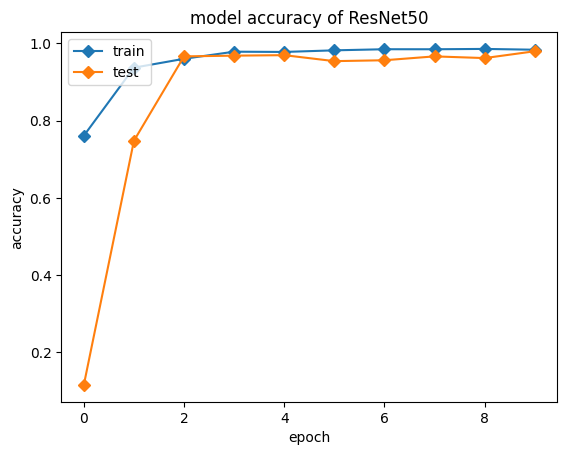

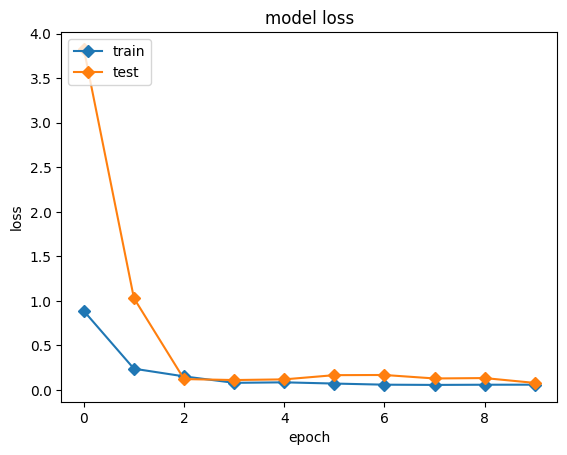

In [ ]:
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **3.2 Модель VGG16:**

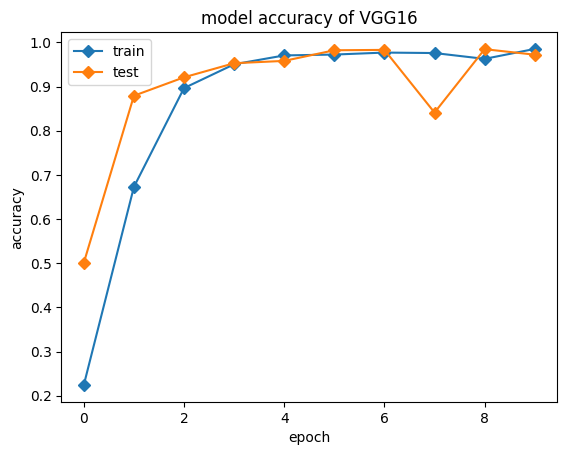

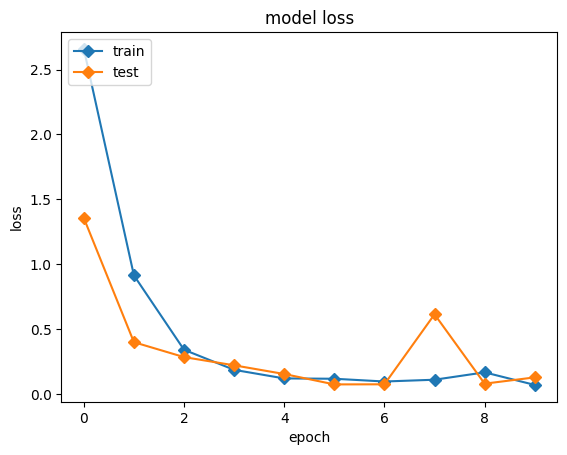

In [ ]:
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Задание II. Применить нецелевую атаку уклонения на основе белого ящика против моделей глубокого обучения**

Реализовать следующие типы атак: Fast Gradient Sign Method (FGSM) и Projected Gradient Descent (PGD).

Может быть использован код из следующих библиотек: Adversarial Robustness Toolbox ART, Cleverhans CH, scratchai SC. Наиболее проработанная библиотека – Adversarial Robustness Toolbox, рекомендуется использовать её, но другие также могут быть применены.

Используйте атаки FSGM и PGD для создания нецелевых атакующих примеров используя первые 1,000 изображений из тестового множества.

Необходимо использовать следующие значения параметра искажения: 𝜖𝜖=[1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255].

Постройте графики точности 2-х моделей в зависимости от параметра искажений 𝜖𝜖.

Для атаки FGSM, отобразите исходное изображение из датасета и атакующее изображение с указанием величины параметра 𝜖𝜖= [1/255, 5/255, 10/255, 50/255, 80/255], отобразите предсказанный класс атакующего изображения.

**Отчёт должен содержать:**

(a) Заполненную таблицу. Все модели должны иметь точность менее 60% для 𝜖𝜖=10/255 (Пункт 6);

(b) Для каждой модели постройте график зависимости точности классификации от параметра искажений 𝜖𝜖 (Пункты 2 и 4);

(c) Сделать выводы о полученных результатах (Пункт 5).

### **1. Начнем с работы с моделью ResNet50:**

#### **1.1 Загрузим сохраненную ранее модель ResNet50 и берем тысячу первых элементов из тестового множества, создаем классификатор ART:**

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

#### **1.2 Реализуем атаку FGSM на ResNet50:**

In [ ]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.7749 - loss: 1.3380
Adv Loss: 1.3404003381729126
Adv Accuracy: 0.7639999985694885
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9200 - loss: 0.4029
True Loss: 0.3709506690502167
True Accuracy: 0.9229999780654907
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6388 - loss: 2.3694
Adv Loss: 2.4332520961761475
Adv Accuracy: 0.6190000176429749
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9200 - loss: 0.4029
True Loss: 0.3709506690502167
True Accuracy: 0.9229999780654907
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5504 - loss: 3.2086
Adv Loss: 3.3109006881713867
Adv Accuracy: 0.5329999923706055
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9200 - loss: 0.4029
True Loss: 0.3709506690502167
True Accuracy: 0.9229999780654907
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4617 - loss: 3.9318
Adv Lo

#### **1.3 Cохраним результаты атаки FGSM на ResNet50 для дальнейшего использования в построении графиков:**

In [ ]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

#### **1.4 Отображаем исходное и Adversarial изображения для разных значений eps после атаки FGSM на ResNet50:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


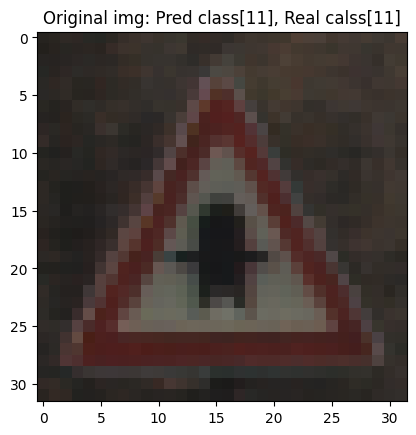

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


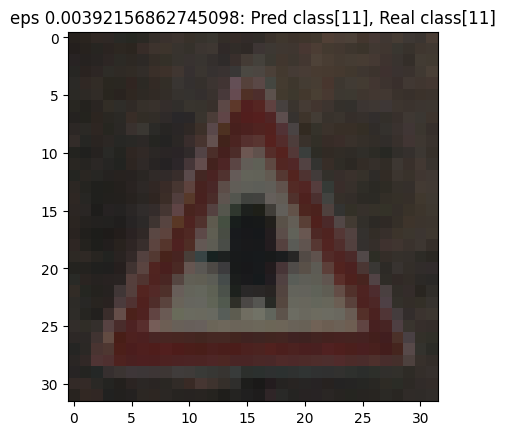

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


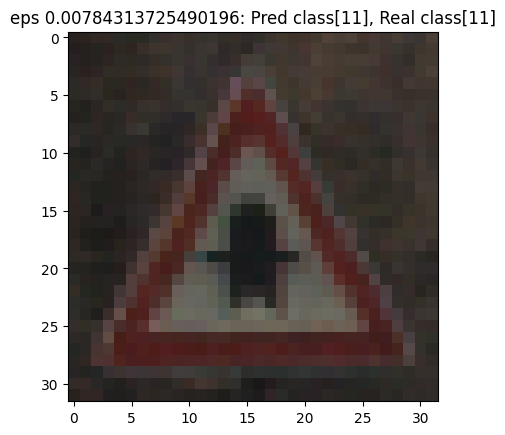

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


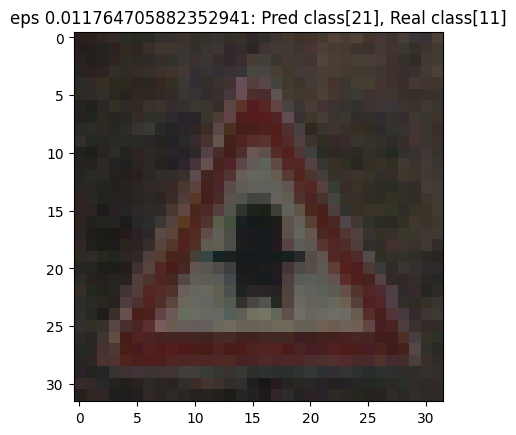

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


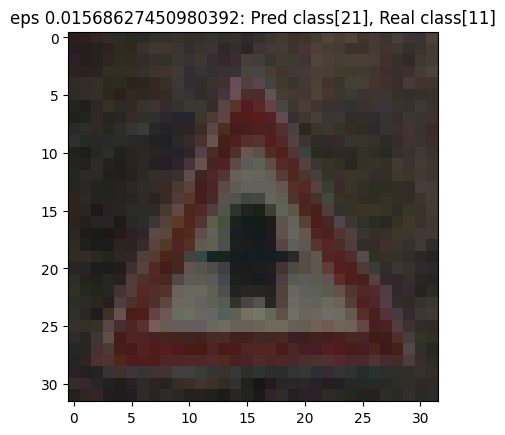

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


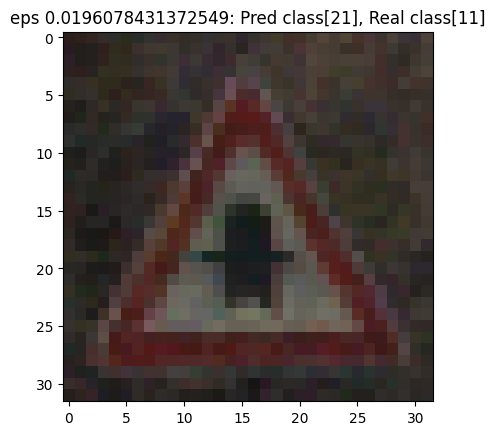

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


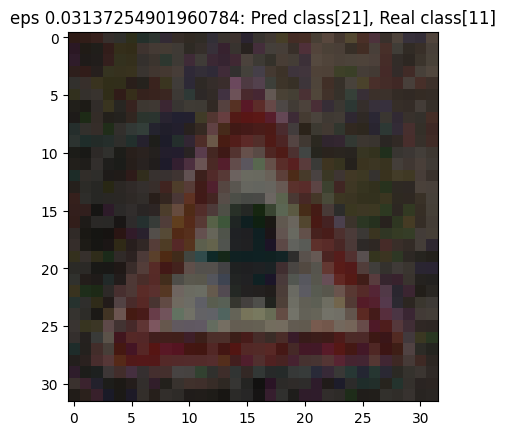

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


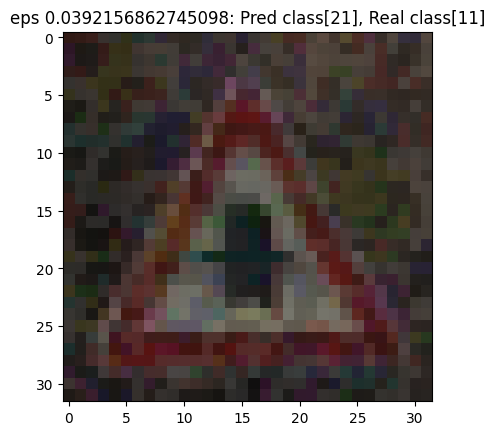

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


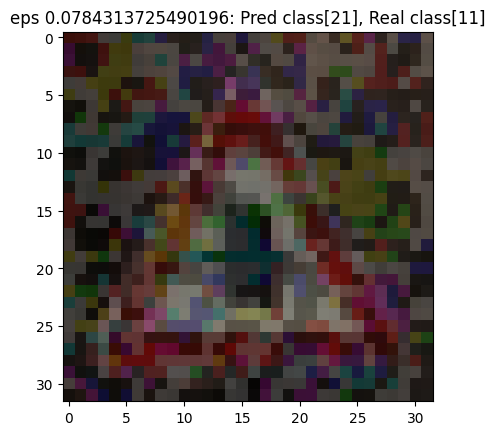

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


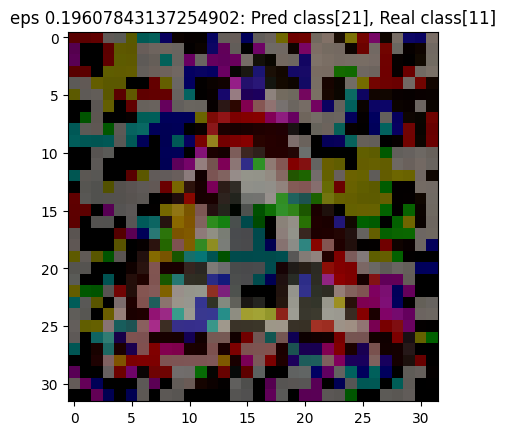

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


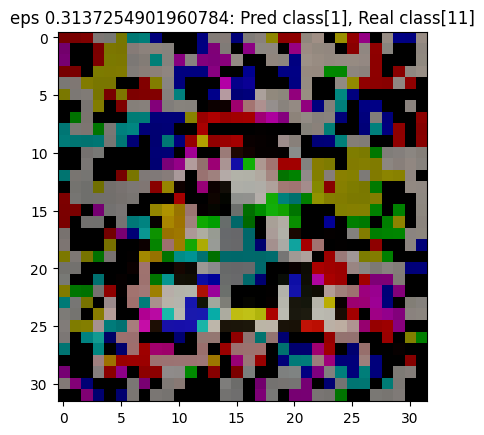

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

#### **1.5 Перейдем к реализации атаки PGD для модели ResNet50:**

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7395 - loss: 1.6200
Adv Loss: 1.6212588548660278
Adv Accuracy: 0.7279999852180481
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9200 - loss: 0.4029
True Loss: 0.3709506690502167
True Accuracy: 0.9229999780654907
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6049 - loss: 2.7745
Adv Loss: 2.9563851356506348
Adv Accuracy: 0.5830000042915344
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9200 - loss: 0.4029
True Loss: 0.3709506690502167
True Accuracy: 0.9229999780654907
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5109 - loss: 3.7069
Adv Loss: 3.850398540496826
Adv Accuracy: 0.5019999742507935
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9200 - loss: 0.4029
True Loss: 0.3709506690502167
True Accuracy: 0.9229999780654907
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4307 - loss: 4.7045
Adv Lo

#### **1.6 Cохраним результаты атаки PGD на ResNet50 для дальнейшего использования в построении графиков:**

In [ ]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)

#### **1.7 Отображаем исходное и Adversarial изображения для разных значений eps после атаки PGD на ResNet50:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


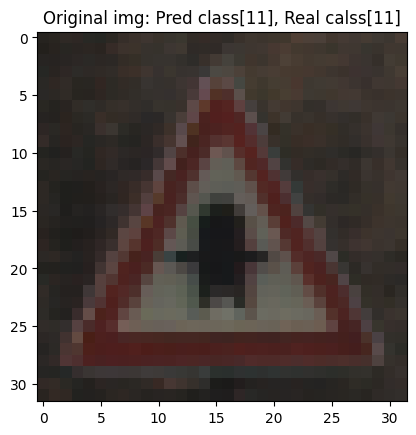

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


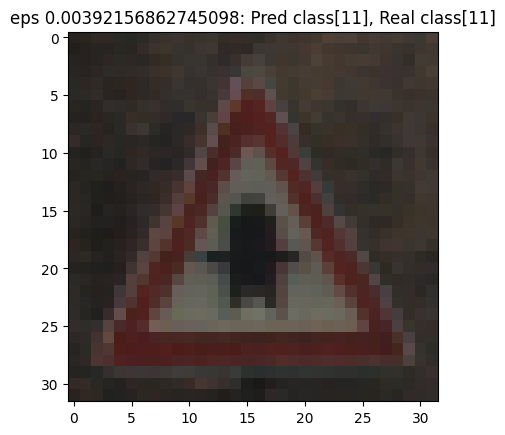

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


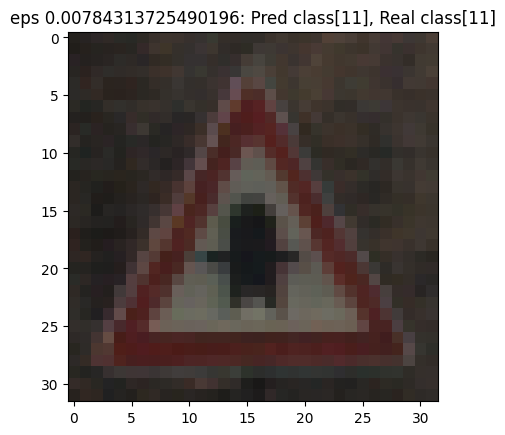

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


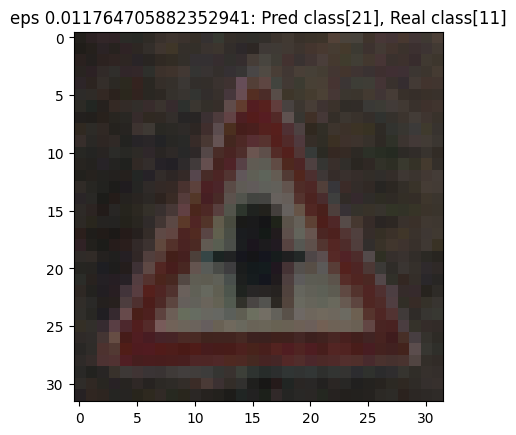

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


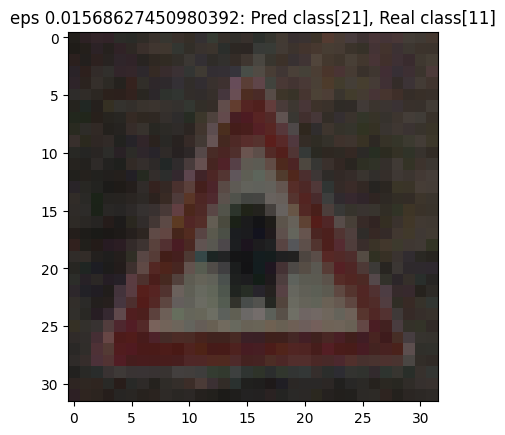

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


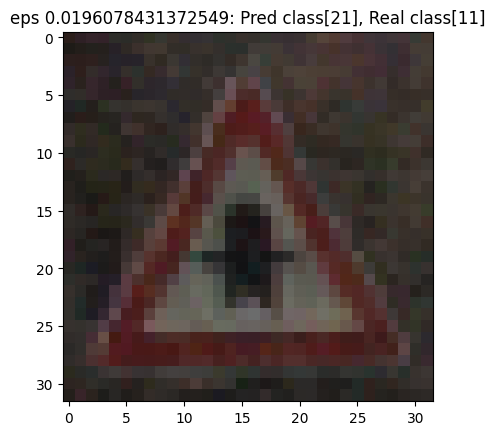

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


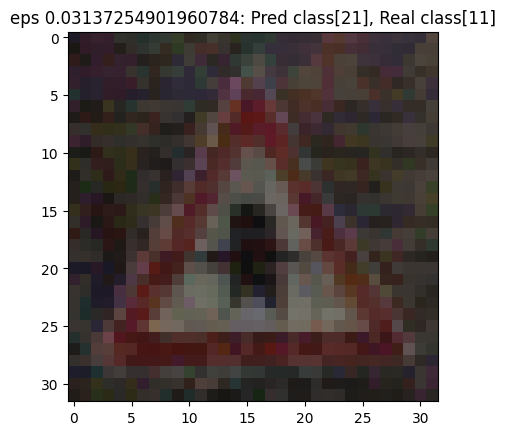

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


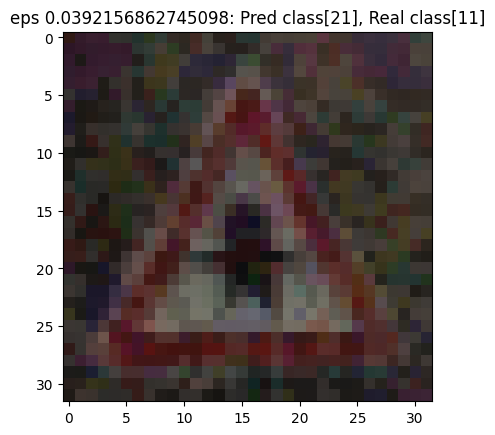

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


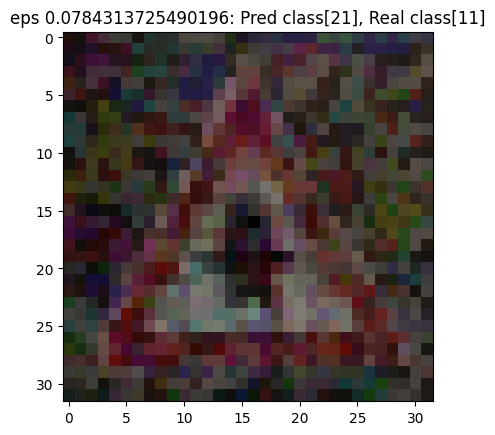

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


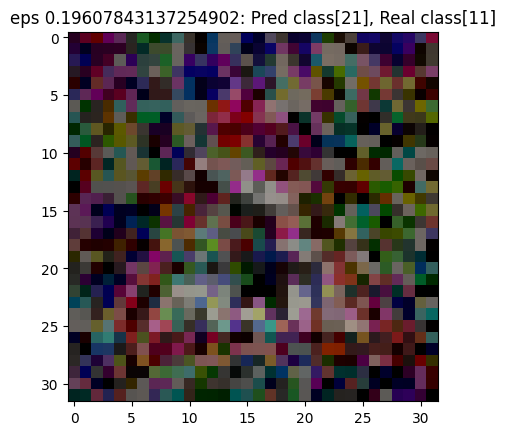

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


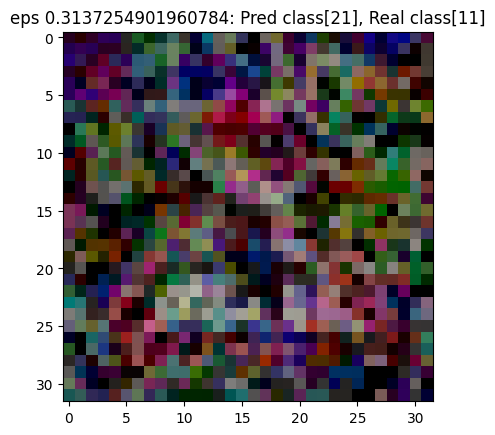

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

### **2. Перейдем к визуализации графиков сравнения полученных результатов по модели ResNet50:**

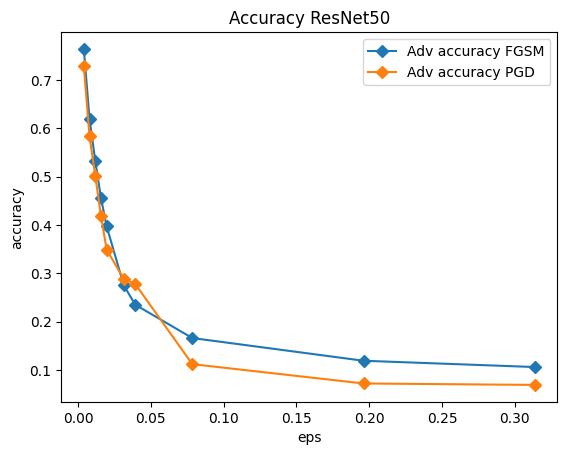

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_ResNet50.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy ResNet50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### **3. Перейдем к работе с моделью VGG16:**

#### **3.1 Загрузим сохраненную ранее модель VGG16 и берем тысячу первых элементов из тестового множества, создаем классификатор ART:**

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

#### **3.2 Реализуем атаку FGSM на VGG16:**

In [ ]:
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_fgsm = []
true_losses = []
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8349 - loss: 1.0103
Adv Loss: 1.0872406959533691
Adv Accuracy: 0.8270000219345093
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9490 - loss: 0.2722
True Loss: 0.32233133912086487
True Accuracy: 0.9399999976158142
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7494 - loss: 1.7512
Adv Loss: 1.89393949508667
Adv Accuracy: 0.7369999885559082
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9490 - loss: 0.2722
True Loss: 0.32233133912086487
True Accuracy: 0.9399999976158142
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6931 - loss: 2.3271
Adv Loss: 2.495690107345581
Adv Accuracy: 0.6809999942779541
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9490 - loss: 0.2722
True Loss: 0.32233133912086487
True Accuracy: 0.9399999976158142
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6504 - loss: 2.6899
Adv Loss

#### **3.3 Cохраним результаты атаки FGSM на VGG16 для дальнейшего использования в построении графиков:**

In [ ]:
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_VGG16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_VGG16", adv_accuracises_fgsm)

#### **3.4 Отображаем исходное и Adversarial изображения для разных значений eps после атаки FGSM на VGG16:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


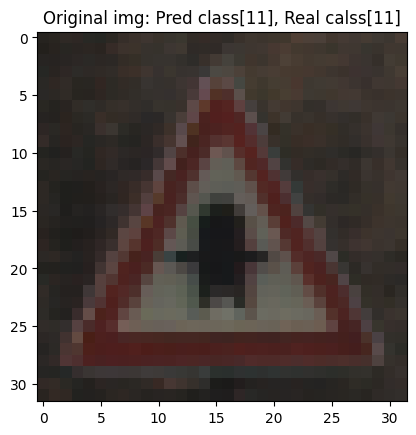

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


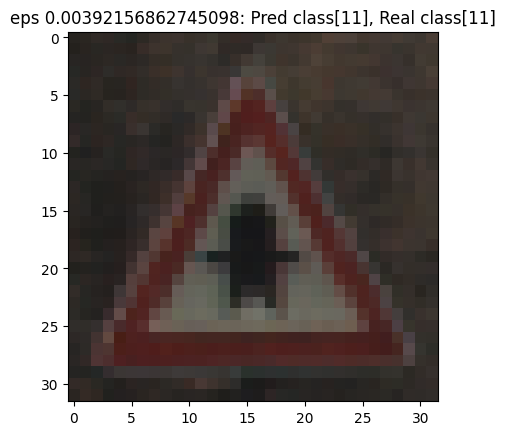

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


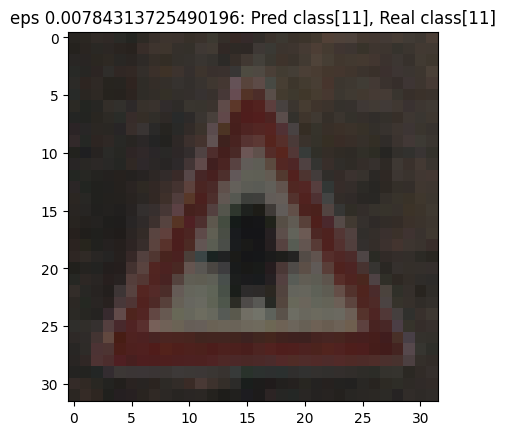

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


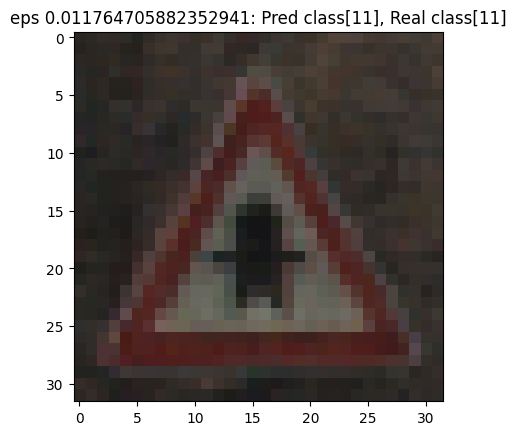

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


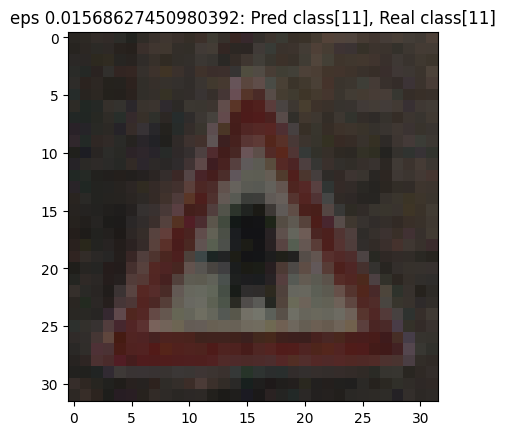

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


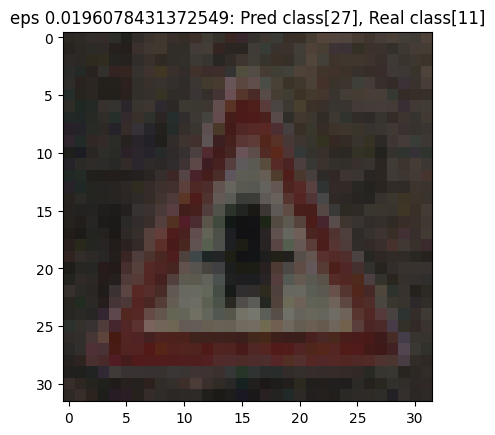

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


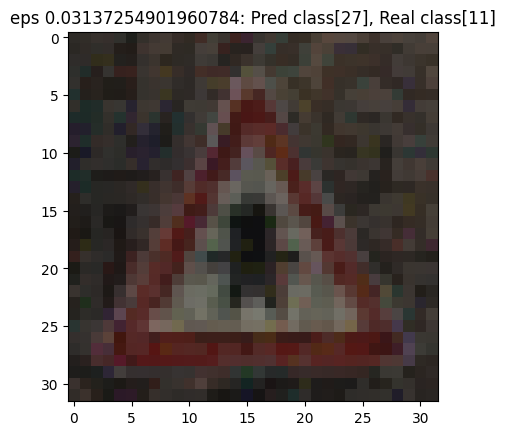

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


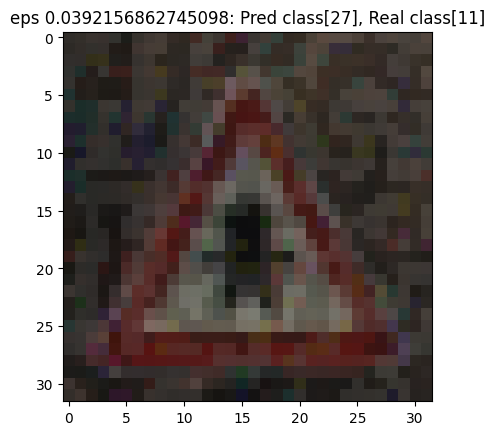

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


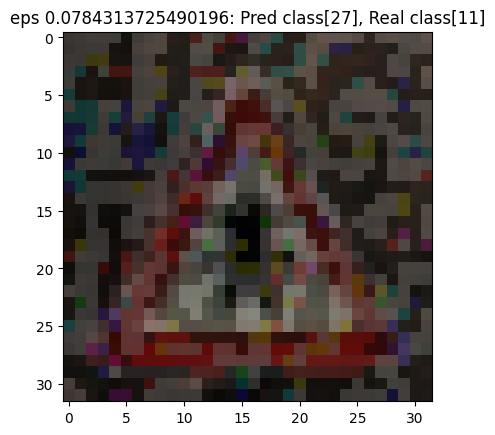

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


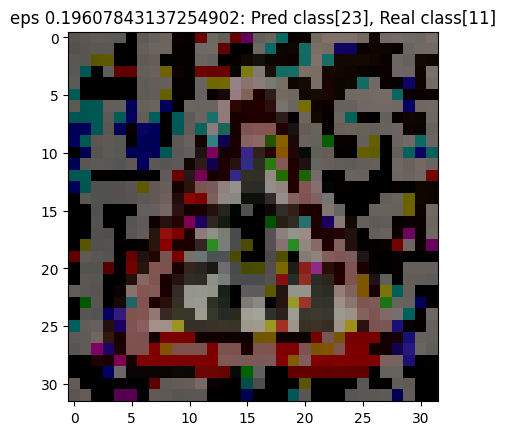

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


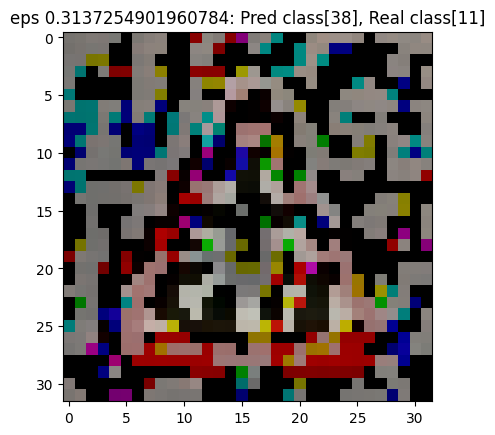

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

#### **3.5 Перейдем к реализации атаки PGD для модели VGG16:**

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)

In [ ]:
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = []
adv_accuracises_pgd = []
true_losses = []
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8262 - loss: 1.1495
Adv Loss: 1.3161226511001587
Adv Accuracy: 0.8159999847412109
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9490 - loss: 0.2722
True Loss: 0.32233133912086487
True Accuracy: 0.9399999976158142
Eps: 0.00784313725490196
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7421 - loss: 2.3750
Adv Loss: 2.606043815612793
Adv Accuracy: 0.7390000224113464
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9490 - loss: 0.2722
True Loss: 0.32233133912086487
True Accuracy: 0.9399999976158142
Eps: 0.011764705882352941
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7112 - loss: 3.4387
Adv Loss: 3.58882999420166
Adv Accuracy: 0.6909999847412109
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9490 - loss: 0.2722
True Loss: 0.32233133912086487
True Accuracy: 0.9399999976158142
Eps: 0.01568627450980392
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6684 - loss: 4.2236
Adv Loss:

#### **3.6 Cохраним результаты атаки PGD на VGG16 для дальнейшего использования в построении графиков:**

In [ ]:
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

#### **3.7 Отображаем исходное и Adversarial изображения для разных значений eps после атаки PGD на VGG16:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


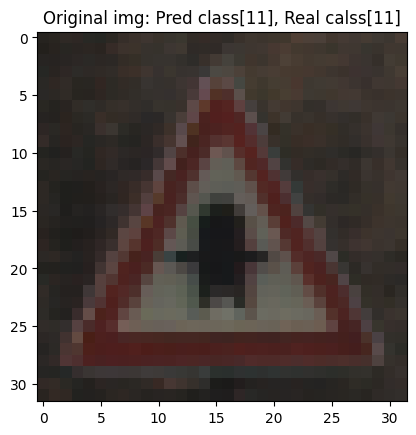

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


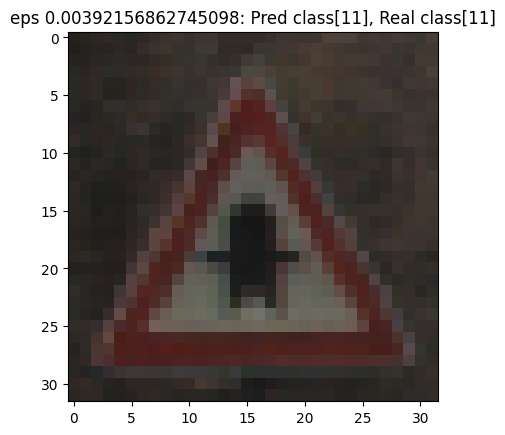

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


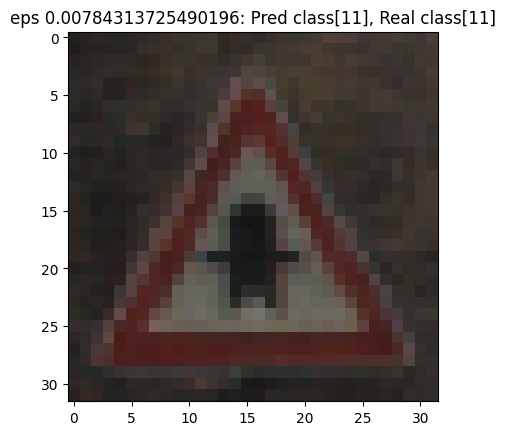

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


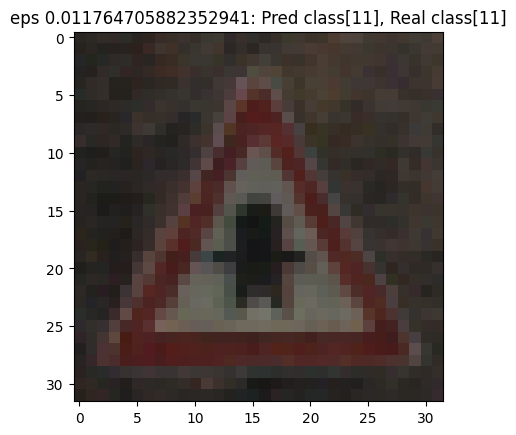

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


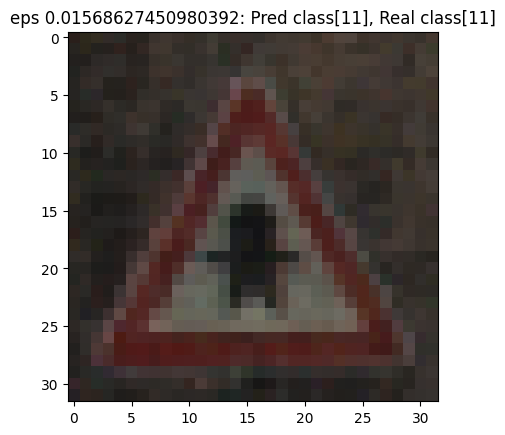

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


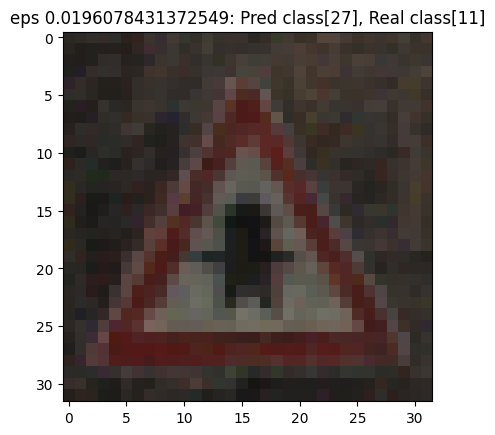

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


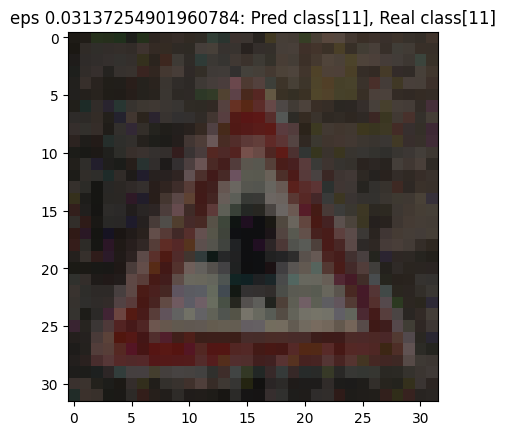

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


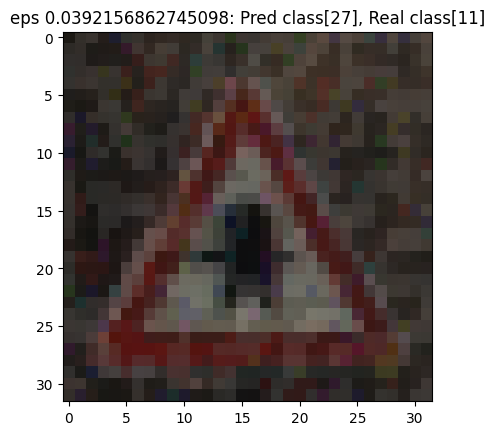

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


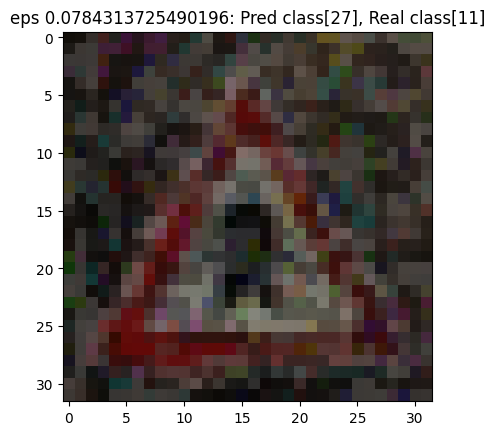

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


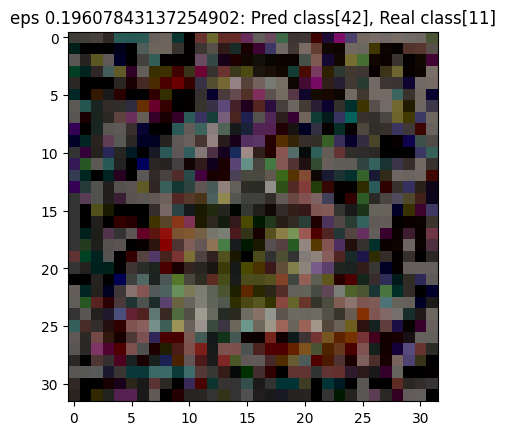

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


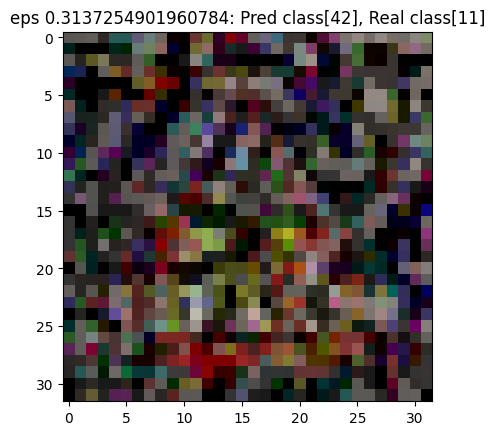

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

### **4. Перейдем к визуализации графиков сравнения полученных результатов по модели VGG16:**

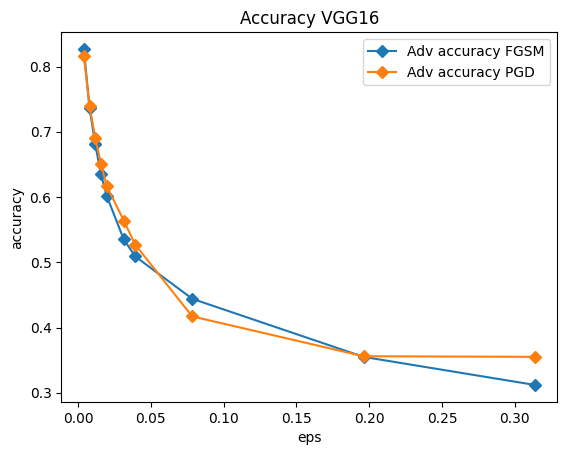

In [ ]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### **5.Выводы по полученным результатам:**

В случае VGG16, при атаках PGD и FGSM сначала наблюдается одинаковое снижение точности. Однако с увеличением значений eps в какой-то момент точность при атаке PGD начинает снижаться более резко. Тем не менее, при максимальном значении eps наибольшее падение точности фиксируется именно при атаке FGSM. Кроме того, атаки в случае VGG16 реализуются кратно быстрее ResNet50.

### **6. Представим итоговую таблицу сравнения по VGG16 и ResNet50:**

In [ ]:
adv_acc_fgsm_rn50 = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_acc_pgd_rn50 = np.load("adv_accuracises_pgd_ResNet50.npy")
adv_acc_fgsm_v16 = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_acc_pgd_v16 = np.load("adv_accuracises_pgd_VGG16.npy")

table = [["Model","Original accuracy","eps = 1/255","eps = 2/255", "eps = 3/255", "eps = 4/255", "eps = 5/255", "eps = 8/255", "eps = 10/255", "eps = 20/255", "eps = 50/255", "eps = 80/255" ],
            ["Resnet50 FGSM",train_accuracy[4]*100,adv_acc_fgsm_rn50[0]*100,
             adv_acc_fgsm_rn50[1]*100,adv_acc_fgsm_rn50[2]*100,adv_acc_fgsm_rn50[3]*100,
             adv_acc_fgsm_rn50[4]*100,adv_acc_fgsm_rn50[5]*100,adv_acc_fgsm_rn50[6]*100,
             adv_acc_fgsm_rn50[7]*100,adv_acc_fgsm_rn50[8]*100,adv_acc_fgsm_rn50[9]*100],
            ["Resnet50 PGD",train_accuracy[4]*100,adv_acc_pgd_rn50[0]*100,
             adv_acc_pgd_rn50[1]*100,adv_acc_pgd_rn50[2]*100,adv_acc_pgd_rn50[3]*100,
             adv_acc_pgd_rn50[4]*100,adv_acc_pgd_rn50[5]*100,adv_acc_pgd_rn50[6]*100,
             adv_acc_pgd_rn50[7]*100,adv_acc_pgd_rn50[8]*100,adv_acc_pgd_rn50[9]*100],
            ["VGG16 FGSM",train_accuracy2[4]*100,adv_acc_fgsm_v16[0]*100,
             adv_acc_fgsm_v16[1]*100,adv_acc_fgsm_v16[2]*100,adv_acc_fgsm_v16[3]*100,
             adv_acc_fgsm_v16[4]*100,adv_acc_fgsm_v16[5]*100,adv_acc_fgsm_v16[6]*100,
             adv_acc_fgsm_v16[7]*100,adv_acc_fgsm_v16[8]*100,adv_acc_fgsm_v16[9]*100],
            ["VGG16 PGD",train_accuracy2[4]*100,adv_acc_pgd_v16[0]*100,
             adv_acc_pgd_v16[1]*100,adv_acc_pgd_v16[2]*100,adv_acc_pgd_v16[3]*100,
             adv_acc_pgd_v16[4]*100,adv_acc_pgd_v16[5]*100,adv_acc_pgd_v16[6]*100,
             adv_acc_pgd_v16[7]*100,adv_acc_pgd_v16[8]*100,adv_acc_pgd_v16[9]*100],]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+
| Model         |   Original accuracy |   eps = 1/255 |   eps = 2/255 |   eps = 3/255 |   eps = 4/255 |   eps = 5/255 |   eps = 8/255 |   eps = 10/255 |   eps = 20/255 |   eps = 50/255 |   eps = 80/255 |
+===============+=====================+===============+===============+===============+===============+===============+===============+================+================+================+================+
| Resnet50 FGSM |             97.7993 |          76.4 |          61.9 |          53.3 |          45.6 |          39.7 |          27.5 |           23.5 |           16.6 |           11.9 |           10.6 |
+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------

**По таблице видно, что точность выше при всех значениях eps у модели VGG16**

## **Задание III. Применение целевой атаки уклонения методом белого против моделей глубокого обучения**

Шаг 1: Используйте изображения знака «Стоп» (label class 14) из тестового
набора данных. Всего имеется 270 изображений. Примените атаку Projected
Gradient Descent (PGD) на знак «Стоп»  с целью классификации его как знака
«Ограничение скорости 30» (target label class = 1). Изменяйте значения
искажений 𝜖𝜖= [1/255, 3/255, 5/255, 10/255, 20/255, 50/255, 80/255], и заполните отчёт значениями точности классификации изображений знаков "Стоп" и"Ограничение скорости 30".  

Шаг 2: Повторите атаку методом FGSM, и объясните производительность по
сравнению с PGD.

**Отчёт должен содержать:**

(a) Заполненную таблицу (Пункт 8);

(b) Постройте 5 примеров исходных изображений знака «Стоп» и соответствующих атакующих (Пункт 3 и 6).

### **1. Загружаем тестовый набор данных из Test.csv и извлекаем изображения с меткой 14, преобразуем изображения в массив чисел и нормализуем:**

In [ ]:
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

### **2. Реализуем целевую атаку FGSM:**

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
tar_accuracises_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    tar_accuracises_fgsm.append(accuracy)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 505ms/step - accuracy: 0.9693 - loss: 0.1290
Adv Loss: 0.19664013385772705
Adv Accuracy: 0.9555555582046509
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0027
True Loss: 0.0032542964909225702
True Accuracy: 1.0
Eps: 0.00784313725490196
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8524 - loss: 0.9192
Adv Loss: 1.0862574577331543
Adv Accuracy: 0.8444444537162781
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027
True Loss: 0.0032542964909225702
True Accuracy: 1.0
Eps: 0.011764705882352941
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7114 - loss: 2.0639
Adv Loss: 2.2176754474639893
Adv Accuracy: 0.7037037014961243
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0027
True Loss: 0.0032542964909225702
True Accuracy: 1.0
Eps: 0.01568627450980392
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5822 - loss: 3.3648
Adv Loss: 3.4640467166900635
Adv Accuracy: 0.5629629

In [ ]:
tar_accuracises_fgsm = np.array(tar_accuracises_fgsm)
np.save("tar_accuracies_fgsm_ResNet50",tar_accuracises_fgsm)

In [ ]:
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

### **3. Отобразим 5 разных изображений для визуализации действия атаки:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


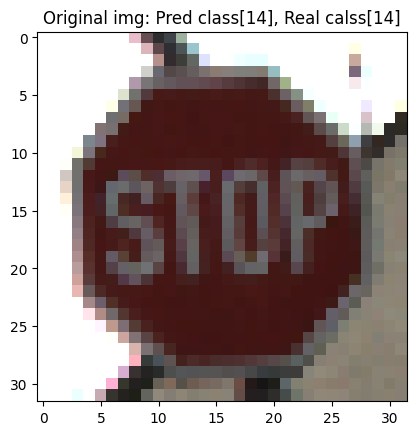

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


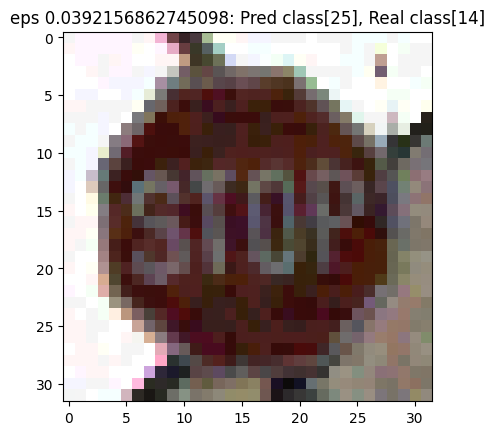

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


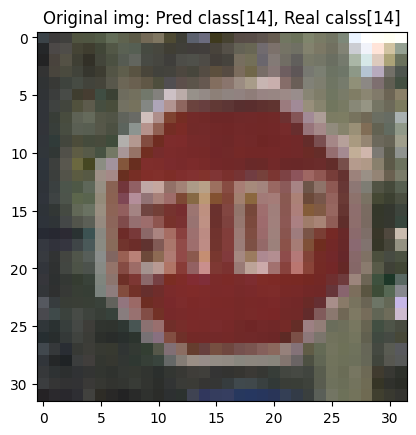

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


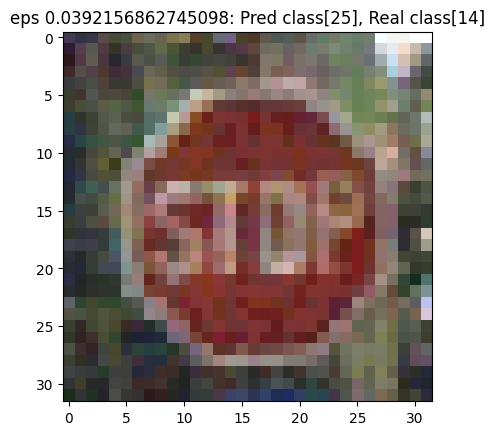

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


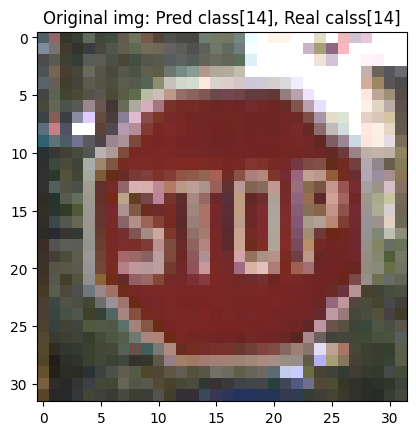

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


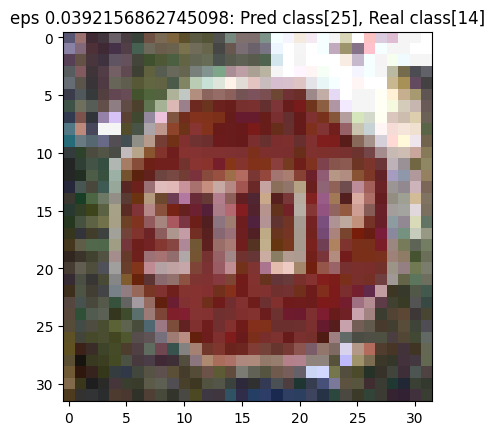

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


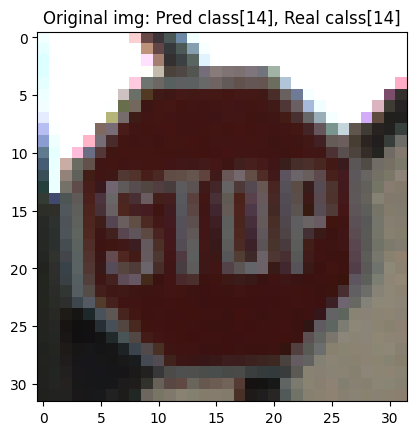

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


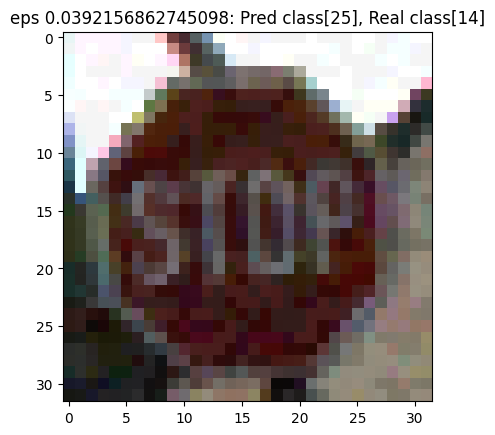

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


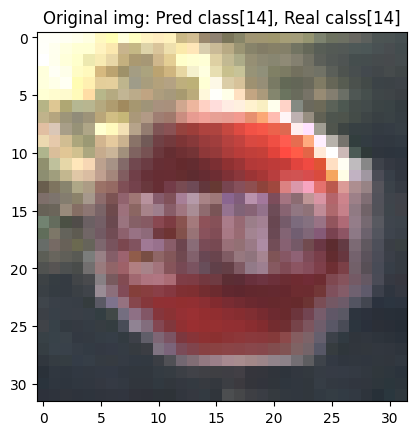

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


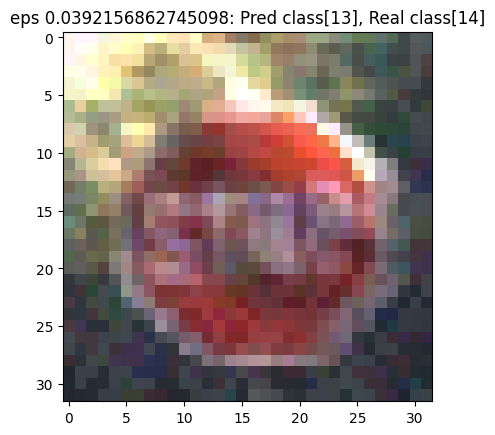

In [ ]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

### **4. Вывод по FGSM:**

Целевая атака FGSM достигает своего пика на eps = 10/255 в нашем случе, при больших значениях eps атака хоть и будет давать больше неточности при предсказании, но это будут разные классы, в большинстве случаев отличные от первого (знак стоп), который мы указали. Можно сделать вывод, что FGSM не очень подходит для целевых атак.

### **5. Реализуем целевую атаку PGD:**

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model=load_model('ResNet50.h5')
nb_classes = 1000
input_shape = (224, 224, 3)
classifier = TensorFlowV2Classifier(model=model, nb_classes=nb_classes, input_shape=input_shape, clip_values=(np.min(x_test), np.max(x_test)), loss_object=loss_object)
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
tar_accuracises_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    tar_accuracises_pgd.append(accuracy)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.9926 - loss: 0.0474
Adv Loss: 0.06993027031421661
Adv Accuracy: 0.9888888597488403
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0027
True Loss: 0.0032542964909225702
True Accuracy: 1.0
Eps: 0.00784313725490196
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9364 - loss: 0.3456
Adv Loss: 0.39050087332725525
Adv Accuracy: 0.9296296238899231
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027
True Loss: 0.0032542964909225702
True Accuracy: 1.0
Eps: 0.011764705882352941
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8576 - loss: 0.9454
Adv Loss: 0.8751853704452515
Adv Accuracy: 0.8666666746139526
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0027
True Loss: 0.0032542964909225702
True Accuracy: 1.0
Eps: 0.01568627450980392
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7997 - loss: 1.2046
Adv Loss: 1.17637038230896
Adv Accuracy: 0.8000000

In [ ]:
tar_accuracises_pgd = np.array(tar_accuracises_pgd)
np.save("tar_accuracies_pgd_ResNet50",tar_accuracises_pgd)

In [ ]:
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

### **6. Отобразим 5 разных изображений для визуализации действия атаки:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


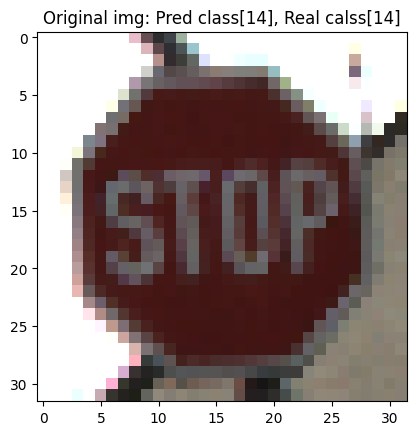

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


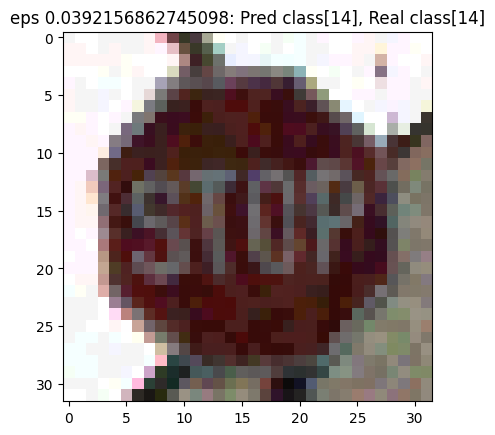

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


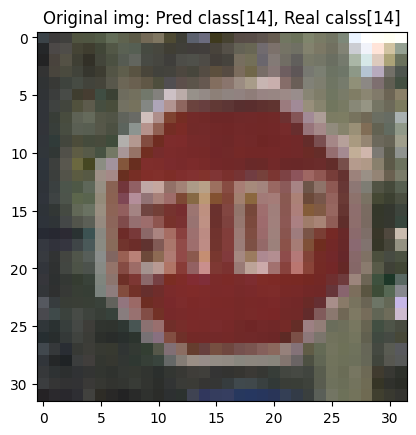

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


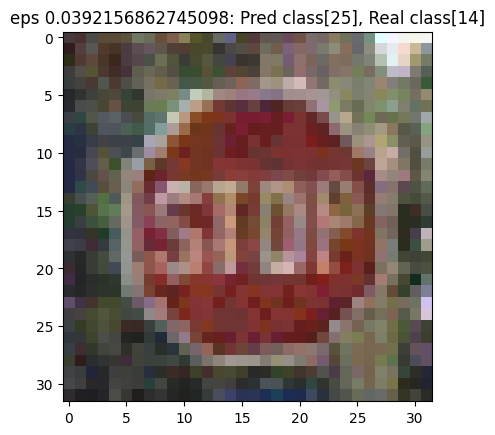

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


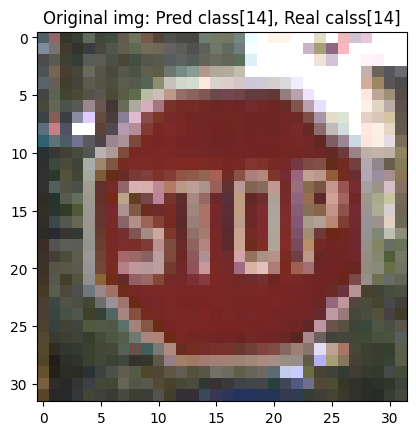

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


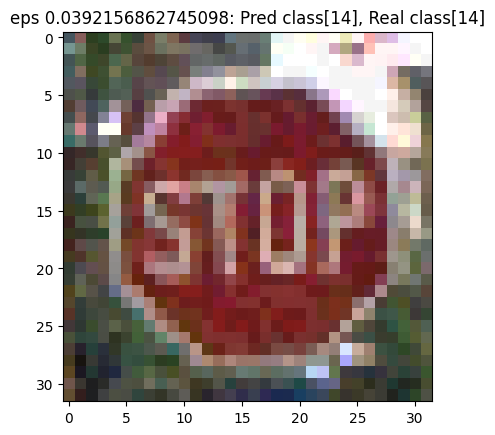

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


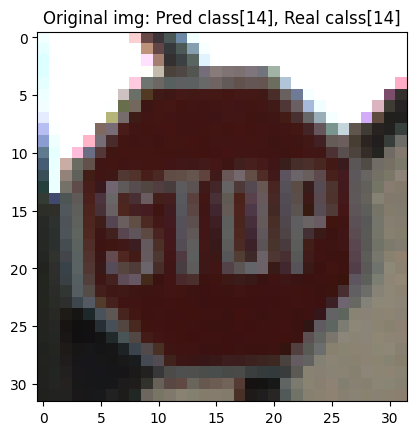

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


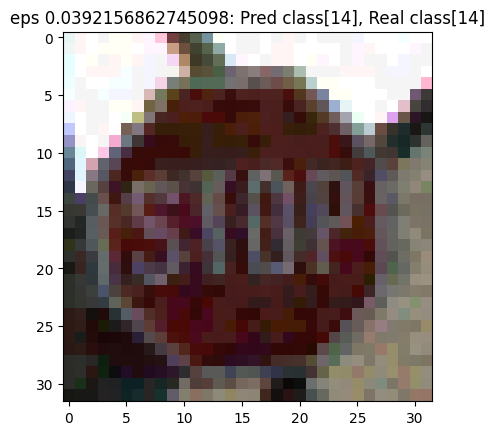

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


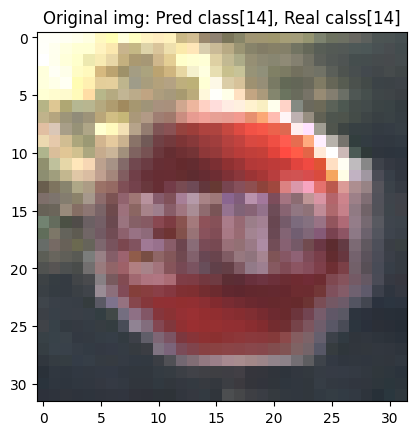

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


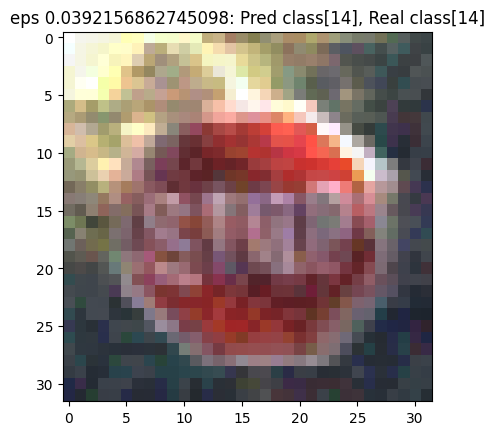

In [ ]:
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

### **7. Вывод таблицы с результатами для сравнения:**

In [ ]:
eps_values_acc = ["1/255", "2/255", "3/255", "4/255", "5/255", "8/255", "10/255", "20/255", "50/255", "80/255"]
tar_acc_fgsm_rn50 = np.load("tar_accuracies_fgsm_ResNet50.npy")
tar_acc_pdp_rn50 = np.load("tar_accuracies_pgd_ResNet50.npy")

table = [["Искажение","FGSM","PGD"],
            [eps_values_acc[0],tar_acc_fgsm_rn50[0],tar_acc_pdp_rn50[0]],
            [eps_values_acc[1],tar_acc_fgsm_rn50[1],tar_acc_pdp_rn50[1]],
            [eps_values_acc[2],tar_acc_fgsm_rn50[2],tar_acc_pdp_rn50[2]],
            [eps_values_acc[3],tar_acc_fgsm_rn50[3],tar_acc_pdp_rn50[3]],
            [eps_values_acc[4],tar_acc_fgsm_rn50[4],tar_acc_pdp_rn50[4]],
            [eps_values_acc[5],tar_acc_fgsm_rn50[5],tar_acc_pdp_rn50[5]],
            [eps_values_acc[6],tar_acc_fgsm_rn50[6],tar_acc_pdp_rn50[6]],
            [eps_values_acc[7],tar_acc_fgsm_rn50[7],tar_acc_pdp_rn50[7]],
            [eps_values_acc[8],tar_acc_fgsm_rn50[8],tar_acc_pdp_rn50[8]],
            [eps_values_acc[9],tar_acc_fgsm_rn50[9],tar_acc_pdp_rn50[9]],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+-------------+------------+-----------+
| Искажение   |       FGSM |       PGD |
+=============+============+===========+
| 1/255       | 0.955556   | 0.988889  |
+-------------+------------+-----------+
| 2/255       | 0.844444   | 0.92963   |
+-------------+------------+-----------+
| 3/255       | 0.703704   | 0.866667  |
+-------------+------------+-----------+
| 4/255       | 0.562963   | 0.8       |
+-------------+------------+-----------+
| 5/255       | 0.42963    | 0.685185  |
+-------------+------------+-----------+
| 8/255       | 0.162963   | 0.603704  |
+-------------+------------+-----------+
| 10/255      | 0.0888889  | 0.696296  |
+-------------+------------+-----------+
| 20/255      | 0.0111111  | 0.396296  |
+-------------+------------+-----------+
| 50/255      | 0.00740741 | 0.0259259 |
+-------------+------------+-----------+
| 80/255      | 0.0037037  | 0.0259259 |
+-------------+------------+-----------+


### **8. Выводы:**

**Атака PGD достигает отличных значений при eps 50/255, при таком значении очень много требуемых результатов.**

**Как видим, атака PGD дольше сохранеяет точность, чем FGSM. При этом PGD намного лучше подходит для целевых атак, так как на больших значениях eps выдает лучший требуемый результат, чем FGSM.**